<a href="https://colab.research.google.com/github/pascca/BERT_eli5/blob/master/FIneTuneYoutube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First Preprocess the data for Huggingface

In [1]:
!pip install transformers==2.8.0
!pip install torch==1.4.0

In [2]:
import transformers
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import nn,optim
from torch.utils import data
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE","#FFDD00", "#FF7D00","#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 6, 6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


Download Daten von Venelin Valkov

In [3]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 4.32MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 63.3MB/s]


Lesen der Files

In [4]:
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [5]:
df.shape

(15746, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


Check Data Balance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'review score')

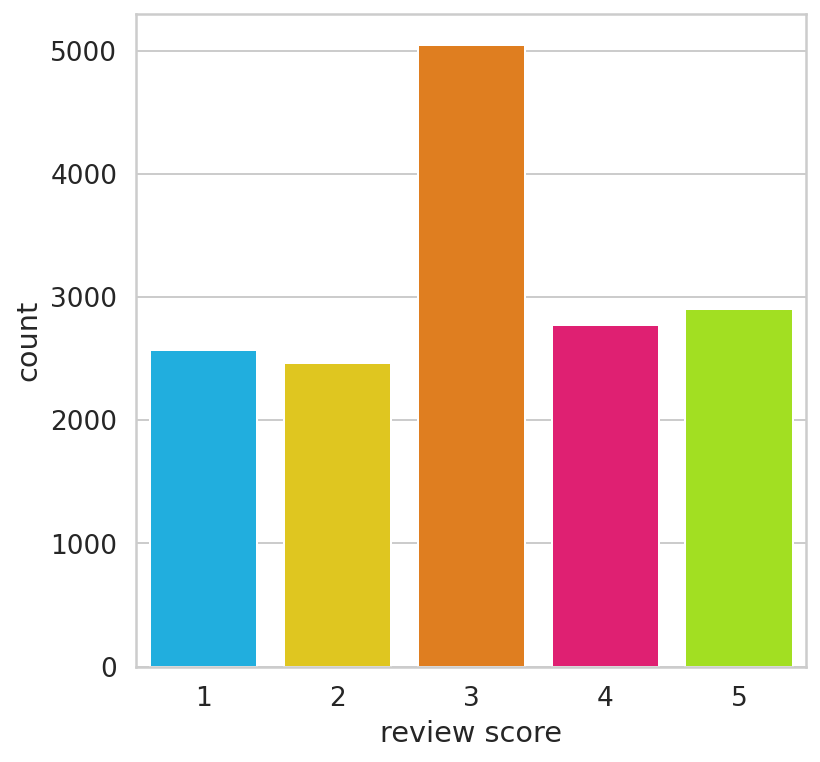

In [7]:
sns.countplot(df.score)
plt.xlabel('review score')

Group 1 and 2 to NEG, 4 and 5 to POS and 3 to NEUTRAL

In [8]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1 
  else:
    return 2

Create new column to dataframe for labels

In [9]:
df['sentiment'] = df.score.apply(to_sentiment)

check Class balances again

In [10]:
class_names = ['negative','neutral','positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

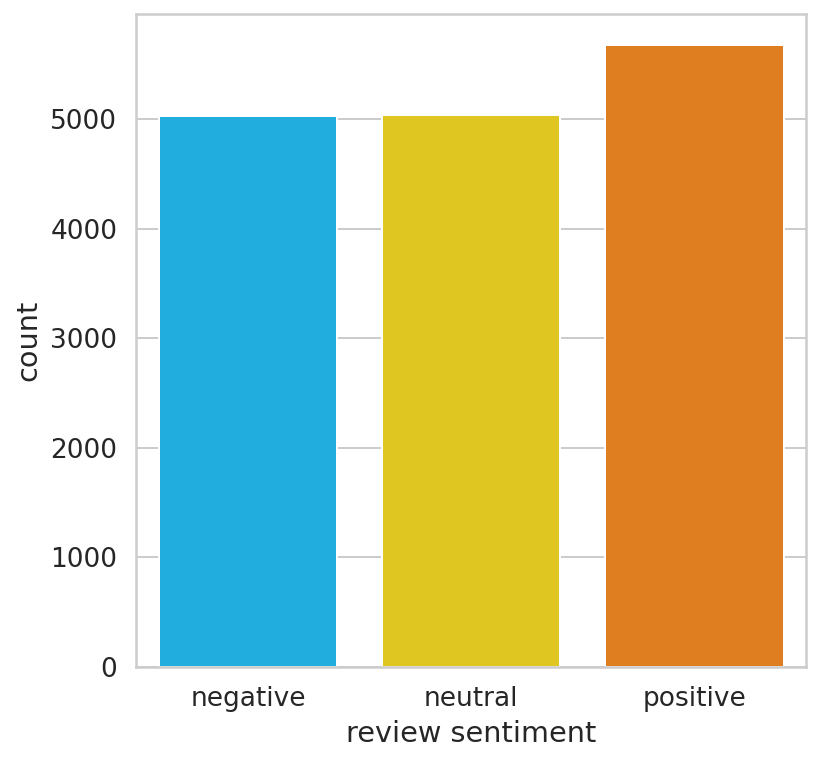

In [11]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

Data Preprocessing now!

In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

In [13]:
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Do Padding and Attention Mask(Every Token with Meaning has a Value of 1 and else 0)

Example with sample text to learn

In [14]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [15]:
tokens = tokenizer.tokenize(sample_txt)

In [16]:
print(tokens)

['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'st', '##uck', 'at', 'home', 'for', '2', 'weeks', '.']


Tokens To IDs which are passed to BERT later

In [17]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [18]:
print(token_ids)

[12242, 10134, 146, 12469, 17555, 136, 146, 10392, 28780, 31746, 10160, 11816, 10142, 123, 20750, 119]


In [19]:
print(f' Sentence: {sample_txt}')
print(f' Tokens: {tokens}')
print(f' Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
 Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'st', '##uck', 'at', 'home', 'for', '2', 'weeks', '.']
 Token IDs: [12242, 10134, 146, 12469, 17555, 136, 146, 10392, 28780, 31746, 10160, 11816, 10142, 123, 20750, 119]


Special Tokens

In [20]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

CLS Tells bert we are interestedin classification

In [21]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [22]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [23]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

Do all the encoding for BERT

In [24]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
    )

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [25]:
encoding['input_ids']

tensor([[  101, 12242, 10134,   146, 12469, 17555,   136,   146, 10392, 28780,
         31746, 10160, 11816, 10142,   123, 20750,   119,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [26]:
len(encoding['input_ids'][0])

32

In [27]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

Choosing seq Length

In [28]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


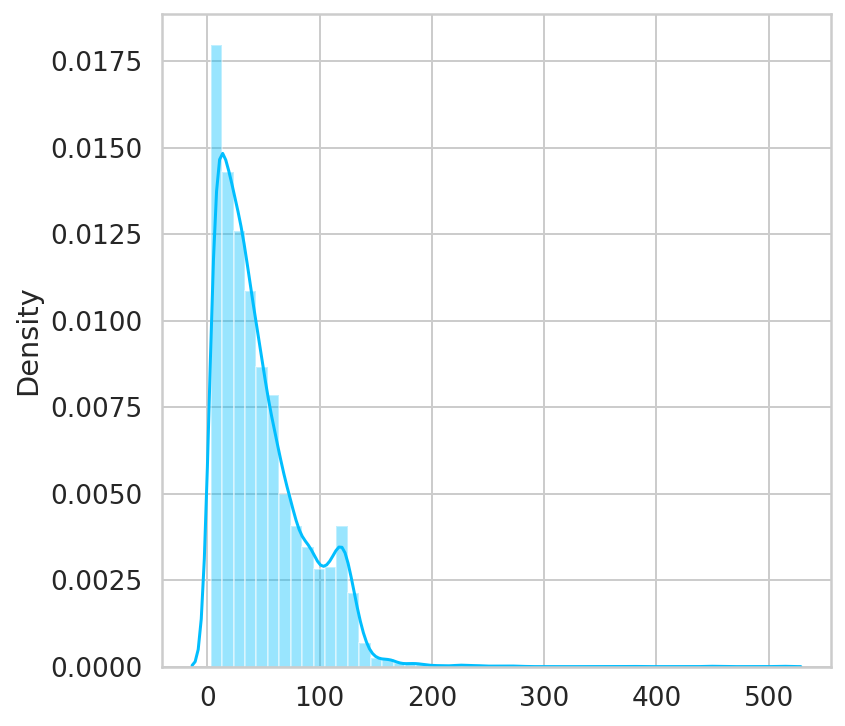

In [29]:
sns.distplot(token_lens)

Create a Dataset

In [30]:
class GPReviewDataset(data.Dataset):

  def __init__(self, review, target, tokenizer, max_len):
    self.review = review
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.review)

  def __getitem__(self, item):
    review = str(self.review[item])
    target = self.target[item]
    encoding = tokenizer.encode_plus(
      review,
      max_length=self.max_len,
      add_special_tokens=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_token_type_ids=False,
      return_tensors='pt'
    )
    
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets' : torch.tensor(self.target[item], dtype=torch.long)
    }

Constants

In [94]:
MAX_LEN =128
BATCH_SIZE = 8
EPOCHS = 6

Create splits with scikit learn

MY DATA

In [95]:
import random

def create_datalist_keras():
	with open("0_a.txt",encoding='utf-8') as f:
		neg = f.readlines()
	with open("1_a.txt",encoding='utf-8') as f:
		pos = f.readlines()
	all_data = []
	all_labels = []
	for a in neg[:200]:
		all_data.append(a.replace("\n",""))
		all_labels.append(0)
	for a in pos:
		all_data.append(a.replace("\n", ""))
		all_labels.append(1)
	c = list(zip(all_data, all_labels))
	random.shuffle(c)
	a, b = zip(*c)
	return list(a), list(b)

In [96]:

tweets, y = create_datalist_keras()
d = {'content': tweets, 'sentiment': y}
df = pd.DataFrame(data=d)
print(df)


                                               content  sentiment
0    @Elquee "Heute finden, dass eine 21-Jährige ni...          0
1    @frankschellhase @Kttel6 @Tino_Chrupalla Oh ma...          1
2    @wavecrestthinks *Die Zahl der Impfdosen wird ...          0
3                    @bengt__r Vielleicht search?q=🚓 ?          0
4    @Banshee_112 Sieht doch lecker aus 🤤👍🏼 Klar, s...          0
..                                                 ...        ...
295  @marbrumm @Karl_Lauterbach Du glaubst aber auc...          1
296  @v_Wittgenstein Sehr geehrte Frau von Sayn-Wit...          0
297  @zuckerfresse @TheManiacGirl29 @zimbo97_ Sind ...          0
298  @SimonRosner @Natascha_Strobl @WRiedler @OlafG...          1
299  Die (angeblich) erste Dosis #Impfstoff ging an...          1

[300 rows x 2 columns]


In [97]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [98]:
df_train.shape, df_val.shape, df_test.shape

((240, 2), (30, 2), (30, 2))

Create Data Loader for Pytorch

In [99]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      review=df.content.to_numpy(),
      target=df.sentiment.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
  )
  return data.DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=1
  )

Loaders for different datasplits

In [100]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Iterate over Dataloader with next(iter(

In [101]:
p = next(iter(train_data_loader))
p.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [102]:
print(p['input_ids'].shape)
print(p['attention_mask'].shape)
print(p['targets'].shape)

torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])


HERE MODEL IS DEFINED AND BUILT

load model

In [103]:
bert_model = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Call Model using input ids and attention mask. Returns Last hidden state from last encoder of bert and pooled output
UPDATE: return_dict = False for Tuples

In [104]:
last_hidden_state, pooled_output = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
)

In [105]:
last_hidden_state.shape

torch.Size([1, 32, 768])

Bert Pooler: tanh function on last hidden state

In [106]:
pooled_output.shape

torch.Size([1, 768])

Building the classifier now

In [107]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.1)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask,
    )
    output = self.drop(pooled_output)
    return self.out(output)

Initializing Classifier

In [108]:
!nvidia-smi

Wed Mar 17 20:11:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    30W /  70W |   7008MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [109]:
model = SentimentClassifier(2)
model = model.to('cuda')

Input Ids and Attention masks to gpu as well
REMEMBER p = data

In [110]:
input_ids = p['input_ids'].to('cuda')
attention_mask = p['attention_mask'].to('cuda')

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([8, 128])
torch.Size([8, 128])


feed data to model

In [111]:
torch.functional.F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4725, 0.5275],
        [0.5217, 0.4783],
        [0.4574, 0.5426],
        [0.4799, 0.5201],
        [0.4229, 0.5771],
        [0.4507, 0.5493],
        [0.4656, 0.5344],
        [0.4687, 0.5313]], device='cuda:0', grad_fn=<SoftmaxBackward>)

How training works

In [112]:
optimizer = transformers.AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to('cuda')

Helper function for training

In [113]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to('cuda')
    attention_mask = d['attention_mask'].to('cuda')
    targets = d['targets'].to('cuda')

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    _, preds = torch.max(outputs,dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # _ in end means in_place
    # gradient clip is a hack to make sure gradients dont become too large
    optimizer.step()
    scheduler.step() # adjusts learning_rate
    optimizer.zero_grad() # zero out losses before next step

  return correct_predictions.double()/n_examples , np.mean(losses)
  # return number of correct predictions and mean loss



Function to evaluate model

In [114]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad(): # disable gradient function to make torch faster while eval
    for d in data_loader:

      input_ids = d['input_ids'].to('cuda')
      attention_mask = d['attention_mask'].to('cuda')
      targets = d['targets'].to('cuda')

      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
      )

      _, preds = torch.max(outputs,dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples , np.mean(losses)


Create Training Loop with eval function

In [115]:

from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}' )
  print('-' * 10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      'cuda',
      scheduler,
      len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      'cuda',
      len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)

  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc < best_accuracy:
    torch.save(model.state_dict(), 'model.pth')
    best_accuracy = val_acc



Epoch 1/6
----------
Train loss 0.5650319874286651 accuracy 0.6791666666666667
Val loss 0.44384337961673737 accuracy 0.6666666666666666

Epoch 2/6
----------
Train loss 0.37277256871263187 accuracy 0.7625
Val loss 0.4446265995502472 accuracy 0.7333333333333333

Epoch 3/6
----------
Train loss 0.30452768231431643 accuracy 0.8833333333333333
Val loss 0.6162327080965042 accuracy 0.7333333333333333

Epoch 4/6
----------
Train loss 0.0869558415065209 accuracy 0.975
Val loss 1.128327526152134 accuracy 0.7333333333333333

Epoch 5/6
----------
Train loss 0.022772160172462464 accuracy 0.9958333333333333
Val loss 1.324001856148243 accuracy 0.7333333333333333

Epoch 6/6
----------
Train loss 0.03627626126011212 accuracy 0.9874999999999999
Val loss 1.5249891057610512 accuracy 0.7333333333333333



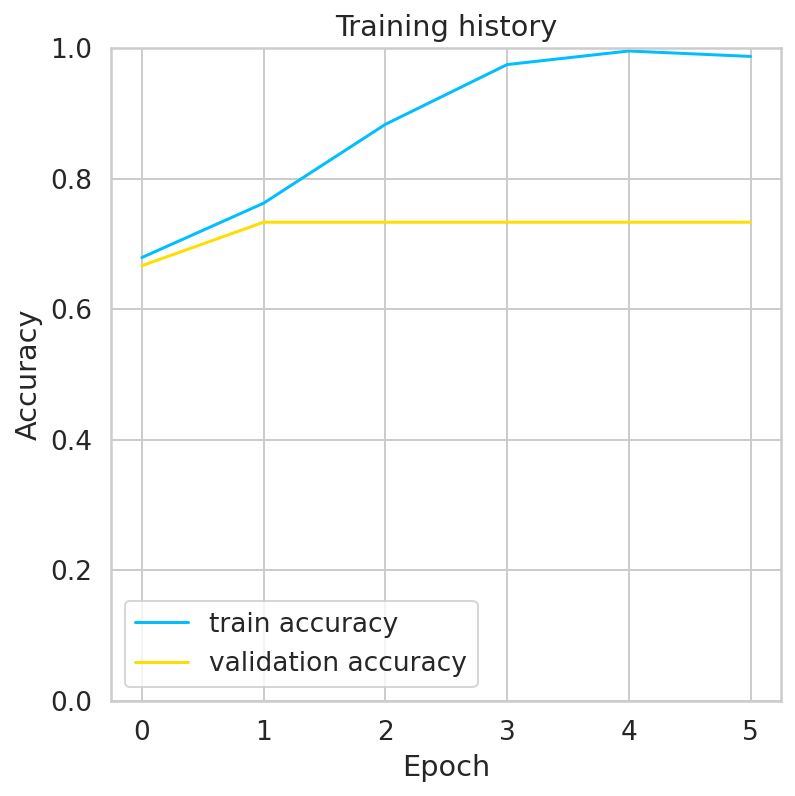

In [116]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

SAVE MODEL FOR EVAL

In [117]:
#MODEL_PATH = 'aufk_model1.bin'
#torch.save(model.state_dict(), MODEL_PATH)

#model = SentimentClassifier(2)
#model.load_state_dict('aufk_model1.bin')
#model = model.to('cuda')

EVALUATION

In [118]:
def get_reviews(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad(): # disable gradient function to make torch faster while eval
    for d in data_loader:
      texts = d['review_text']
      input_ids = d['input_ids'].to('cuda')
      attention_mask = d['attention_mask'].to('cuda')
      targets = d['targets'].to('cuda')

      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
      )

      _, preds = torch.max(outputs,dim=1)
      
      review_texts.extend(texts) # same as append but for more values at once 
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu() # make tensors of lists
  prediction_probs = torch.stack(prediction_probs).cpu() # make tensors of lists
  real_values = torch.stack(real_values).cpu() # make tensors of lists

  return review_texts, predictions, prediction_probs, real_values


In [119]:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn,'cuda',len(df_test))
print(test_acc)

tensor(0.8667, device='cuda:0', dtype=torch.float64)


In [120]:
y_review_texts, y_pred, y_pred_probs, y_test = get_reviews(model, test_data_loader)

In [121]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.79      0.92      0.85        12

    accuracy                           0.87        30
   macro avg       0.86      0.88      0.86        30
weighted avg       0.88      0.87      0.87        30



In [122]:
for a in range(len(y_review_texts)):
  print(y_review_texts[a]+" --- "+ str(y_pred[a])+" | "+str(y_pred_probs[a])+" | "+ str(y_test[a]))

War nur als Platzhalter gedacht, weil ich eine gewisse beschönigende Tendenz sehe, wenn es um das Verhalten dieser Bevölkerungsgruppe geht. Genauso schlimm ist, dass der ursprüngliche Clip inzwischen gelöscht wurde. Man will nicht, dass Einzelfälle instrumentalisiert werden. 😂🤡 --- tensor(0) | tensor([ 3.2484, -3.7909]) | tensor(0)
@SenGPG @dil_kal Wieviele Berliner wurden heute geimpft? --- tensor(1) | tensor([-3.0333,  3.2467]) | tensor(1)
Einfach mal 5 Tage Selbstisolation, Corona-Test und trotzdem mit schlechtem Gewissen Eltern besuchen fahren, weil sie sich das so sehr gewünscht haben. Nur um sich so respektlos wie noch nie vom Papa behandeln zu lassen. Nächste Pandemie hör ich auf euch und bleib zu Hause. --- tensor(0) | tensor([ 3.2687, -3.8544]) | tensor(0)
@petertauber Schon geimpft worden??? --- tensor(0) | tensor([ 2.5614, -2.9117]) | tensor(0)
@Karl_Lauterbach Guten Tag Herr Lauter, ich schätze ihre offene und unaufgeregte Art zum Thema Corona. Können sie mir bitte nachvoll

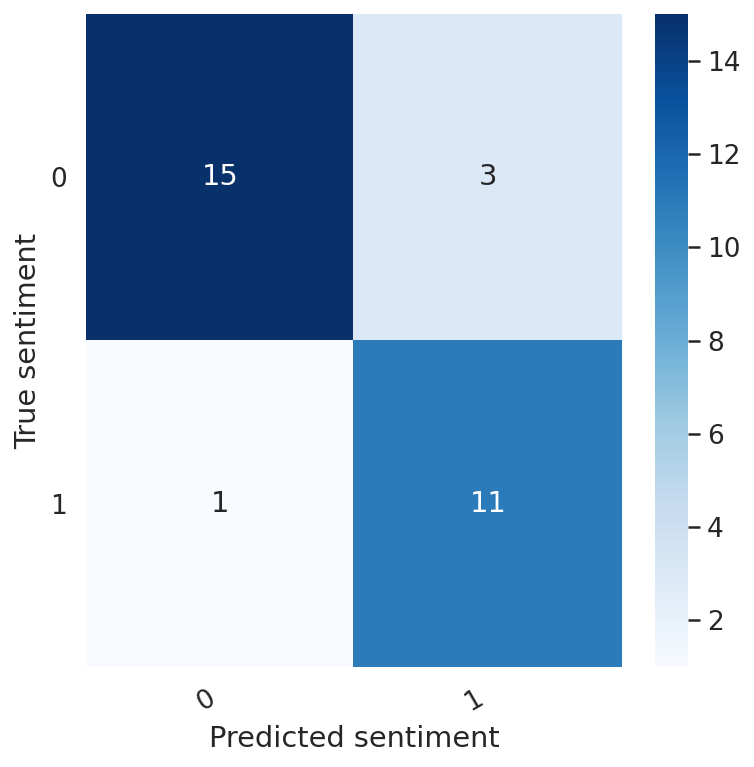

In [123]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=["0","1"], columns=["0","1"])
show_confusion_matrix(df_cm)

PREDICT SENTIMENT ON RAW TEXT

In [130]:
twt = "Ich frag mich wann meine Oma geimpft werden kann?"

In [131]:
encoded_review = tokenizer.encode_plus(
  twt,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [132]:
input_ids = encoded_review['input_ids'].to('cuda')
attention_mask = encoded_review['attention_mask'].to('cuda')
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {twt}')
print(f'Sentiment  : {[0,1][prediction]}')

Review text: Ich frag mich wann meine Oma geimpft werden kann?
Sentiment  : 1
